### Постановка целей и задач. 


----
Цель: проведение исследования данных и построение прогноза развития пандемии COVID19 в Великобритании.

Задачи:
- провести анализ данных о распространении COVID19 в Великобритании;
- выявить взаимосвязи между ключевыми событиями в данных в Великобритании;
- построить прогноз распространения пандемии COVID19 в Великобритании.
---


### Импорт  библиотек, написание функций.

In [4]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 39.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
!pip install fbprophet

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

 
from statsmodels.tsa.statespace.sarimax import SARIMAX       
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              
from fbprophet import Prophet                                
from statsmodels.tsa.holtwinters import ExponentialSmoothing 


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

#Импортируем данные

In [7]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [8]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


### Знакомство с данными.

Этот блок посвящен первоначальному знакомству с данными

Наша задача - посмотреть на данные методами .info(), а также изучить их визуально.
Источник данных и его описание находится тут https://github.com/owid/covid-19-data/tree/master/public/data

Мои метрики для прогнозирования:

1) total_cases - накопительный итоги кол-во новых случаев заболеваний

2) new_cases - новые случаи заболеваний за день

3) total_deaths - накопительный итоги кол-во смертей

4) new_deaths - новые случаи смертей за день


---

#Общая информация о датасете

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149256 entries, 0 to 149255
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    149256 non-null  object 
 1   continent                                   140249 non-null  object 
 2   location                                    149256 non-null  object 
 3   date                                        149256 non-null  object 
 4   total_cases                                 146646 non-null  float64
 5   new_cases                                   146640 non-null  float64
 6   new_cases_smoothed                          145495 non-null  float64
 7   total_deaths                                129628 non-null  float64
 8   new_deaths                                  129823 non-null  float64
 9   new_deaths_smoothed                         145495 non-null  float64
 

#Cписок доступных стран

In [10]:
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

---
Я выбираю  Великобританию, то есть df.location == United Kingdom

---

## Предобработка данных

### Фильтрация данных

---
Фильтрую данные по условию df.location == United Kingdom, выбирая признаки: дата (день), страна и показатели (кол-во новых случаев заражения, смертей и соответствующие им итоговые значение в день)

---


In [11]:
df_new = df[df.location == 'United Kingdom'][['location', 'date', 'new_deaths', 'new_cases', 'total_cases', 'total_deaths']]

In [12]:
df_new.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
140409,United Kingdom,2020-01-31,NaN,2.0,2.0,NaN
140410,United Kingdom,2020-02-01,NaN,0.0,2.0,NaN
140411,United Kingdom,2020-02-02,NaN,0.0,2.0,NaN
140412,United Kingdom,2020-02-03,NaN,6.0,8.0,NaN
140413,United Kingdom,2020-02-04,NaN,0.0,8.0,NaN


### Обработка пропусков

---
Так как пропуски (NaN) находятся из-за недоступности данных на определенный день, можно считать в такие дни, что показатель = 0.




In [13]:
df_new.isna()

,location,date,new_deaths,new_cases,total_cases,total_deaths
140409,False,False,True,False,False,True
140410,False,False,True,False,False,True
140411,False,False,True,False,False,True
140412,False,False,True,False,False,True
140413,False,False,True,False,False,True
...,...,...,...,...,...,...
141096,False,False,False,False,False,False
141097,False,False,False,False,False,False
141098,False,False,False,False,False,False
141099,False,False,False,False,False,False


In [14]:
df_check_nan = df_new.isna()

Проверям есть пропуски в признаке


In [15]:
for i in df_check_nan.columns:
    print(f'Для признака {i} пропуски: ', df_check_nan[i].unique())

Для признака location пропуски:  [False]
Для признака date пропуски:  [False]
Для признака new_deaths пропуски:  [ True False]
Для признака new_cases пропуски:  [False]
Для признака total_cases пропуски:  [False]
Для признака total_deaths пропуски:  [ True False]


Меняем на 0

In [16]:
df_new = df_new.fillna(0)

In [17]:
df_new.dtypes

location         object
date             object
new_deaths      float64
new_cases       float64
total_cases     float64
total_deaths    float64
dtype: object

---
Необходимо для location и date поменять тип данных для корректного считывания и отображения

---

In [18]:
df_new['location'] = df_new['location'].astype('string')

df_new['date'] = pd.to_datetime(df_new['date'])

In [19]:
df_new.dtypes

location                string
date            datetime64[ns]
new_deaths             float64
new_cases              float64
total_cases            float64
total_deaths           float64
dtype: object

### Вывод по этапу.

---
Мы импортировали данные, взяли на входи четыре признака (total_cases,new_cases,total_deaths,new_deaths) из исходного датасета.
Сделали фильтрацию по условию  df.loction == Великобритания.
А также сделали обработку пропусков и заменили их на 0,  чтобы не прерывать временной ряд.

---

## EDA (exploratory data analysis) или разведочный анализ данных. 

---


Задачи данного блока: 
- Сделать столбец с датами индексом;
- Вывести статистику по нужным столбцам;
- Построить графическое отображение столбцов;
- Выявить связи между признаками (почему заболеваемость может расти или падать и тп).

---

In [20]:
df_new.index = df_new.date

In [21]:
len(df_new)

692

Входная выборка для анализа

In [22]:
df_new.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2020-01-31,United Kingdom,2020-01-31,0.0,2.0,2.0,0.0
2020-02-01,United Kingdom,2020-02-01,0.0,0.0,2.0,0.0
2020-02-02,United Kingdom,2020-02-02,0.0,0.0,2.0,0.0
2020-02-03,United Kingdom,2020-02-03,0.0,6.0,8.0,0.0
2020-02-04,United Kingdom,2020-02-04,0.0,0.0,8.0,0.0


Расчет основных статистических метрик

In [23]:
df_new.describe()

,new_deaths,new_cases,total_cases,total_deaths
count,692.000000,692.000000,6.920000e+02,692.000000
mean,213.417630,16864.666185,3.325223e+06,82245.971098
std,312.290841,18331.470291,3.209741e+06,49925.002622
min,0.000000,-4860.000000,2.000000e+00,0.000000
25%,18.000000,2042.750000,2.968200e+05,41089.750000
50%,84.000000,7126.000000,3.098722e+06,81768.500000
75%,233.000000,30208.750000,4.865796e+06,128279.500000
max,1820.000000,105626.000000,1.167035e+07,147685.000000


Общий график для метрик

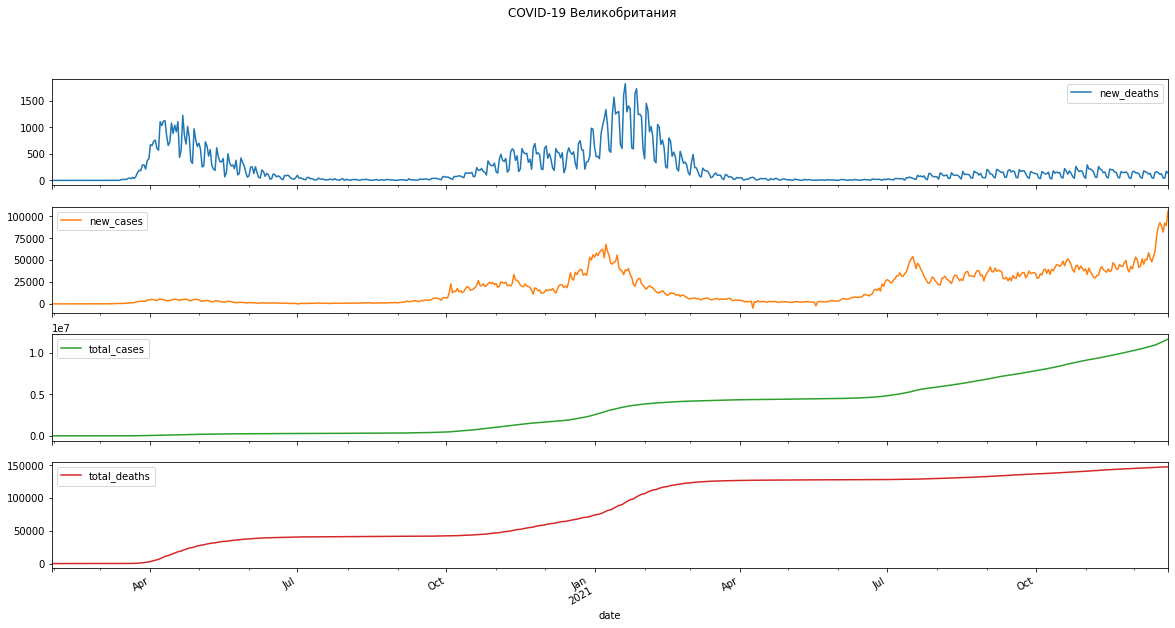

In [24]:
df_new[['new_deaths', 'new_cases', 'total_cases', 'total_deaths']].plot(subplots=True, figsize=(20, 10), title = 'COVID-19 Великобритания');

---
Промежуточный вывод:

Максимальное значение новых заражений **92713**, а максимальное значение новых смертельных случаев **1820**, что уже говорит о низкой летальности заболеваний.
Обращаясь к данным медицинской статистики можно сделать вывод о том, чем менее летальный вирус, тем больше у него охват заражения.

---

Гистограмма для определения распределения данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadc5030d10>,
      dtype=object)

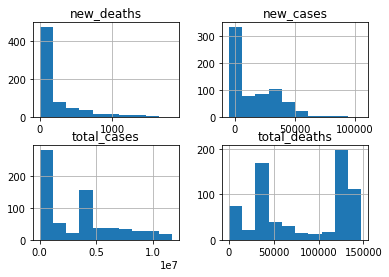

In [25]:
df_new.hist()

---
Промежуточный вывод:

Анализ представленного ненормального распределения позволяет сделать вывод о пиковых нагрузках в период пандемии. Это отчетливо видно на общем графике:при этом последний сопровождается большим кол-вом смертей.

---

Матрица корреляции признаков

In [26]:
df_new.corr()

,new_deaths,new_cases,total_cases,total_deaths
new_deaths,1.000000,0.217657,-0.107733,-0.110606
new_cases,0.217657,1.000000,0.725726,0.554367
total_cases,-0.107733,0.725726,1.000000,0.907785
total_deaths,-0.110606,0.554367,0.907785,1.000000


График зависимости total_cases от total_deaths

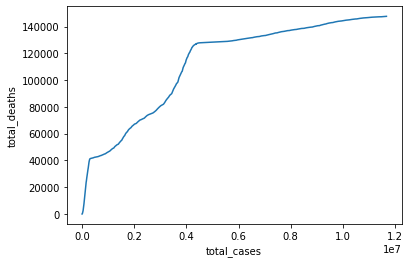

In [27]:
sns.lineplot(data = df_new, x = 'total_cases', y = 'total_deaths')

График плотности распределения total_cases

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



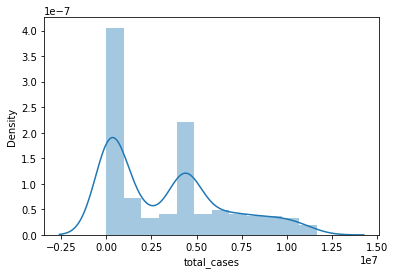

In [28]:
sns.distplot(df_new.total_cases)

График плотности распределения total_deaths

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



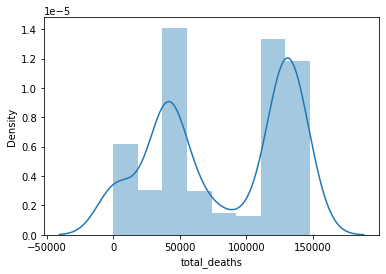

In [29]:
sns.distplot(df_new.total_deaths)

---
Промежуточный вывод:

Видим высокий уровень корреляции между кол-вом заболеваний и смертей, что свидетельствует о воздействии сходных факторов на уровень заболеваемости и общей смертности, где на графике видна практически близкая к линейной зависимости этих двух признаков.


---

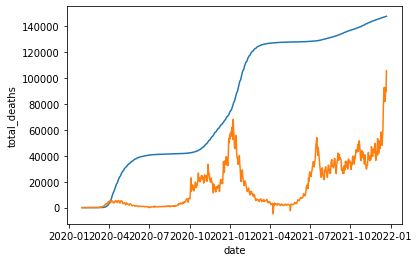

In [30]:
sns.lineplot(data = df_new, x = 'date', y = 'total_deaths')
sns.lineplot(data = df_new, x = 'date', y = 'new_cases')

## Построение моделей, анализ результатов.

### Обучающая/контрольная выборки

In [31]:
train = df_new.iloc[:len(df_new)-10]
test = df_new.iloc[len(df_new)-10:]

In [32]:
train.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2020-01-31,United Kingdom,2020-01-31,0.0,2.0,2.0,0.0
2020-02-01,United Kingdom,2020-02-01,0.0,0.0,2.0,0.0
2020-02-02,United Kingdom,2020-02-02,0.0,0.0,2.0,0.0
2020-02-03,United Kingdom,2020-02-03,0.0,6.0,8.0,0.0
2020-02-04,United Kingdom,2020-02-04,0.0,0.0,8.0,0.0


In [33]:
test.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2021-12-13,United Kingdom,2021-12-13,38.0,53953.0,10893795.0,146584.0
2021-12-14,United Kingdom,2021-12-14,150.0,59746.0,10953541.0,146734.0
2021-12-15,United Kingdom,2021-12-15,164.0,77966.0,11031507.0,146898.0
2021-12-16,United Kingdom,2021-12-16,147.0,87801.0,11119308.0,147045.0
2021-12-17,United Kingdom,2021-12-17,113.0,92713.0,11212021.0,147158.0


### ETS декомпозиция

In [ ]:
r = seasonal_decompose(df_new['new_cases'],model='additive')

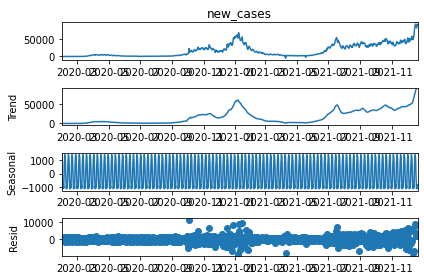

In [ ]:
r.plot();

seasonal_decompose в увеличенном виде

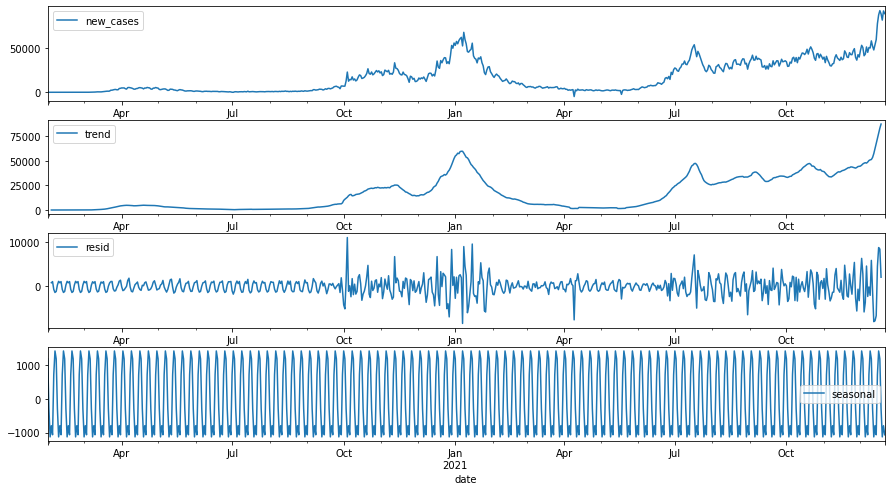

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
r.observed.plot(ax=ax1, legend=True)
r.trend.plot(ax=ax2, legend=True)
r.resid.plot(ax=ax3, legend=True)
r.seasonal.plot(ax=ax4, legend=True)

---
Промежуточный вывод:

На графике представлено распределение в пиковую нагрузку в октябре(2020г.) -феврале(2021г.) ,а также в июне-декабре 2021г. 
Наблюдаем недельную сезонность.

---

### Построение моделей

---
Задачи:
- описать модель
- подобрать оптимальные параметры
- создать модель
- обучить модель
- сделать прогноз на период тестовой выборки
- сравнить прогноз с тестовой выборкой (построить график)
- оценить качество прогноза
- сделать прогноз на 10-15 дней на будущее
- сделать выводы о работе данного метода прогнозирования

---

### 1й метод прогнозирования - SARIMAX

#### Описание модели SARIMAX: 

Модель временных рядов, построенная на основе расширенной (eXtended) модели ARIMA с добавлением сезонности (Seasonal).

In [35]:
auto_arima(df_new['new_cases'],seasonal=True, m=7).summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  692
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -6463.579
Date:                           Thu, 23 Dec 2021   AIC                          12943.158
Time:                                   10:16:18   BIC                          12979.463
Sample:                                        0   HQIC                         12957.200
                                           - 692                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    181.0600    221.915      0.816      0.415    -253.885     616.005
ar.L1         -1.1711      0.082    -14.316      0.000      -1.331      -1.011
ar.L2         -0.1959      0.022     -8.770      0.000      -0.240      -0.152
ma.L1          0.9776      0.081     12.081      0.000       0.819       1.136
ar.S.L7        0.3218      0.141      2.279      0.023       0.045       0.599
ar.S.L14       0.2153      0.061      3.511      0.000       0.095       0.335
ma.S.L7        0.0083      0.147      0.057      0.955      -0.280       0.296
sigma2      7.853e+06      0.062   1.26e+08      0.000    7.85e+06    7.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1336.40
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             118.78   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.07e+22. Standard errors may be unstable.
"""

---
Промежуточные выводы:

Получилась модель с параметрами SARIMAX(2, 1, 1)x(1, 0, 1, 7)

---

In [36]:

model_sarimax = SARIMAX(train['new_cases'],order=(2, 1, 1), seasonal_order=(1, 0, 1, 7))


results_sarimax = model_sarimax.fit()


results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         new_cases   No. Observations:                  682
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -6323.404
Date:                           Thu, 23 Dec 2021   AIC                          12658.807
Time:                                   10:16:26   BIC                          12685.949
Sample:                               01-31-2020   HQIC                         12669.312
                                    - 12-12-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1925      0.031    -38.382      0.000      -1.253      -1.132
ar.L2         -0.2520      0.020    -12.909      0.000      -0.290      -0.214
ma.L1          0.9643      0.029     33.236      0.000       0.907       1.021
ar.S.L7        0.9451      0.026     36.611      0.000       0.895       0.996
ma.S.L7       -0.7813      0.043    -18.122      0.000      -0.866      -0.697
sigma2      6.793e+06   1.55e-09   4.39e+15      0.000    6.79e+06    6.79e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              1216.38
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):              87.93   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.98e+31. Standard errors may be unstable.
"""

In [37]:
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename(' Predictions SARIMAX(2, 1, 1)x(1, 0, 1, 7)	')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



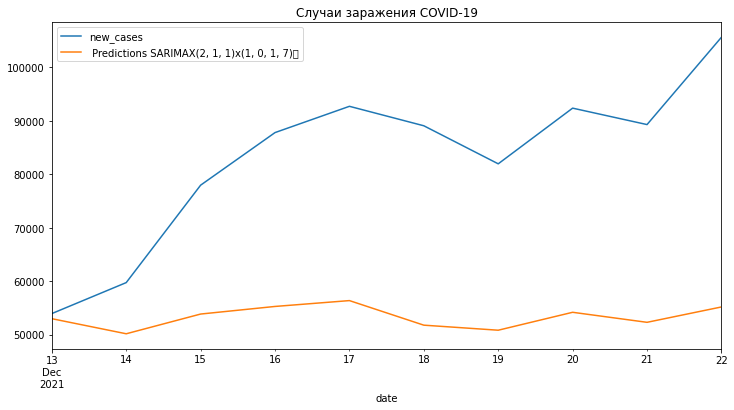

In [38]:
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [39]:
mae_error = mean_absolute_error(test['new_cases'], prediction_sarimax)
mse_error = mean_squared_error(test['new_cases'], prediction_sarimax)
rmse_error = rmse(test['new_cases'], prediction_sarimax)
mape_error = np.mean(np.abs(prediction_sarimax - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(2, 1, 1)x(1, 0, 1, 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(2, 1, 1)x(1, 0, 1, 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(2, 1, 1)x(1, 0, 1, 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(2, 1, 1)x(1, 0, 1, 7) MAPE Error: {mape_error:11.10}')

SARIMAX(2, 1, 1)x(1, 0, 1, 7) MAE Error: 29747.04454
SARIMAX(2, 1, 1)x(1, 0, 1, 7) MSE Error: 1.07779291e+09
SARIMAX(2, 1, 1)x(1, 0, 1, 7) RMSE Error: 32829.75648
SARIMAX(2, 1, 1)x(1, 0, 1, 7) MAPE Error: 33.52403951


Качество модели 33% 

In [41]:
fut_model_sarimax = SARIMAX(df_new['new_cases'],order=(2, 1, 1), seasonal_order=(1, 0, 1, 7))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         new_cases   No. Observations:                  692
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -6465.129
Date:                           Thu, 23 Dec 2021   AIC                          12942.258
Time:                                   10:18:28   BIC                          12969.487
Sample:                               01-31-2020   HQIC                         12952.790
                                    - 12-22-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1591      0.030    -38.997      0.000      -1.217      -1.101
ar.L2         -0.2085      0.023     -9.238      0.000      -0.253      -0.164
ma.L1          0.9763      0.022     43.825      0.000       0.933       1.020
ar.S.L7        0.9864      0.016     62.876      0.000       0.956       1.017
ma.S.L7       -0.8383      0.034    -24.983      0.000      -0.904      -0.773
sigma2      9.032e+06   1.55e-09   5.81e+15      0.000    9.03e+06    9.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1379.02
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):             103.30   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.18e+30. Standard errors may be unstable.
"""

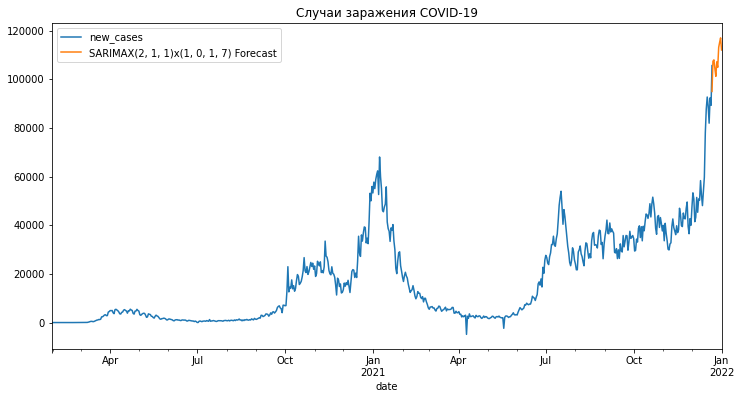

In [42]:
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels').rename('SARIMAX(2, 1, 1)x(1, 0, 1, 7) Forecast')

ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

### Выводы работы метода SARIMAX

---
Мы сравнивнили прогноз и тестовую выборку. Прогноз сильно отличается от тестовый выборки. Оценили качество модели на 33%. Сделали прогноз на будущее - 10 дней вперед. Прогноз на будущее показал,что будет рост заболеваймости COVID19.

---

### 2й метод прогнозирования - PROPHET

Это библиотека с открытым исходным кодом от компании Facebook. Она предназначена для прогнозирования временных рядов



 Данные для модели. Переименовали столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet

In [43]:
train_prophet = train[['date','new_cases']]
test_prophet = test[['date','new_cases']]


train_prophet.columns = ['ds', 'y'] 
test_prophet.columns = ['ds', 'y'] 

In [44]:
df_new_prophet = df_new[['date','new_cases']]
df_new_prophet.columns = ['ds', 'y'] 

In [45]:
model_prophet = Prophet(seasonality_mode='multiplicative') 
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---
Промежуточные выводы:

Алгоритм проигнорировал, выбирая параметры

1. `Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.`

    - годовую сезонность (*для годовой сезонности нам нужно иметь данные минимум за 2 года, чтобы суметь использовать ее в модели*)


2. `INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.`

    - дневную сезонность (*дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам*).

Зато он обнаружил недельную сезонность и использовал его при настройке модели.

---

Делаем  дата-фрейм на 10 дней вперед

In [46]:
future_prophet = model_prophet.make_future_dataframe(periods=10)

In [47]:
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-01-31,158.970849,-9266.924101,9888.548795,158.970849,158.970849,0.078473,0.078473,0.078473,0.078473,0.078473,0.078473,0.0,0.0,0.0,171.445699
1,2020-02-01,171.904643,-9489.433131,9998.146107,171.904643,171.904643,-0.024285,-0.024285,-0.024285,-0.024285,-0.024285,-0.024285,0.0,0.0,0.0,167.729957
2,2020-02-02,184.838436,-9375.011563,9754.984144,184.838436,184.838436,-0.072208,-0.072208,-0.072208,-0.072208,-0.072208,-0.072208,0.0,0.0,0.0,171.491580
3,2020-02-03,197.772229,-9310.024840,10036.981263,197.772229,197.772229,-0.037066,-0.037066,-0.037066,-0.037066,-0.037066,-0.037066,0.0,0.0,0.0,190.441630
4,2020-02-04,210.706023,-9729.848208,8985.892325,210.706023,210.706023,-0.066839,-0.066839,-0.066839,-0.066839,-0.066839,-0.066839,0.0,0.0,0.0,196.622547


In [48]:
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-01-31,2020-01-31,158.970849,-9266.924101,9888.548795,158.970849,158.970849,0.078473,0.078473,0.078473,0.078473,0.078473,0.078473,0.0,0.0,0.0,171.445699
2020-02-01,2020-02-01,171.904643,-9489.433131,9998.146107,171.904643,171.904643,-0.024285,-0.024285,-0.024285,-0.024285,-0.024285,-0.024285,0.0,0.0,0.0,167.729957
2020-02-02,2020-02-02,184.838436,-9375.011563,9754.984144,184.838436,184.838436,-0.072208,-0.072208,-0.072208,-0.072208,-0.072208,-0.072208,0.0,0.0,0.0,171.491580
2020-02-03,2020-02-03,197.772229,-9310.024840,10036.981263,197.772229,197.772229,-0.037066,-0.037066,-0.037066,-0.037066,-0.037066,-0.037066,0.0,0.0,0.0,190.441630
2020-02-04,2020-02-04,210.706023,-9729.848208,8985.892325,210.706023,210.706023,-0.066839,-0.066839,-0.066839,-0.066839,-0.066839,-0.066839,0.0,0.0,0.0,196.622547


---
Промежуточные выводы:

Основные поля в прогнозе следующие:
- `ds` — дата прогноза
- `yhat` — спрогнозированное значение

---



In [49]:
prediction_prophet[['ds', 'yhat']] 

,ds,yhat
ds,,
2020-01-31,2020-01-31,171.445699
2020-02-01,2020-02-01,167.729957
2020-02-02,2020-02-02,171.491580
2020-02-03,2020-02-03,190.441630
2020-02-04,2020-02-04,196.622547
...,...,...
2021-12-18,2021-12-18,49742.768183
2021-12-19,2021-12-19,47478.624592
2021-12-20,2021-12-20,49462.801785


Сравниваем прогноз и тестовую выборку, где черные точки - выборка

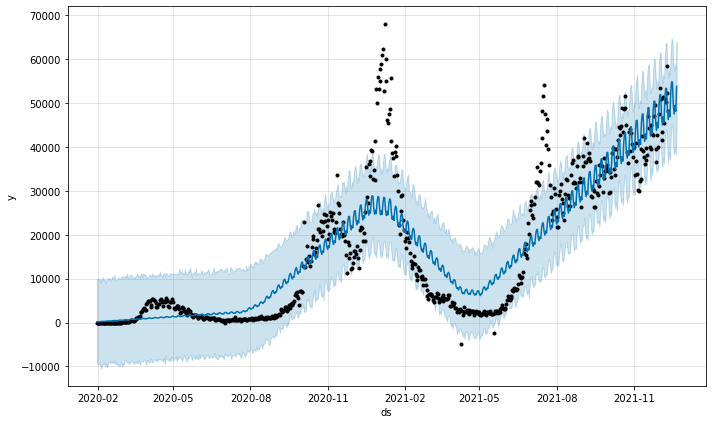

In [50]:
model_prophet.plot(prediction_prophet);

Основные компоненты — тренд и сезонность

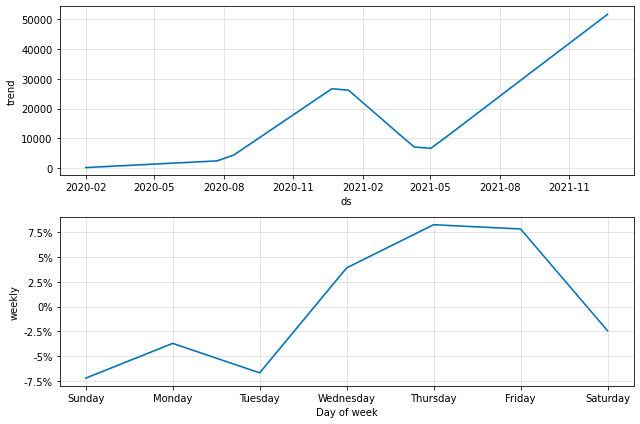

In [51]:
model_prophet.plot_components(prediction_prophet);

#Оценим качество модели методом MSE, RMSE, MAE, MAPE

In [52]:
mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 32498.32015
Prophet MSE Error: 1.234545426e+09
Prophet RMSE Error: 35136.09862
Prophet MAPE Error: 37.15461993


Качество модели 37%

Делаем прогноз на будущее - 10 дней вперед

In [53]:
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_new_prophet)


fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Сравниваем прогноз и всю выборку, где черные точки - входная выборка

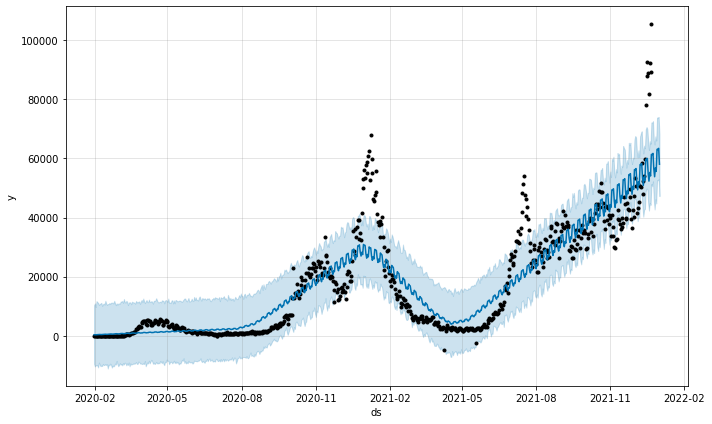

In [54]:
fut_model_prophet.plot(fut_fcast_prophet);

In [55]:
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [56]:
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-01-31,2020-01-31,312.650942,-9578.190529,10340.002128,312.650942,312.650942,0.064816,0.064816,0.064816,0.064816,0.064816,0.064816,0.0,0.0,0.0,332.915798
2020-02-01,2020-02-01,324.104391,-10419.384452,10959.827716,324.104391,324.104391,-0.029199,-0.029199,-0.029199,-0.029199,-0.029199,-0.029199,0.0,0.0,0.0,314.640950
2020-02-02,2020-02-02,335.557839,-10088.882061,9695.057333,335.557839,335.557839,-0.078878,-0.078878,-0.078878,-0.078878,-0.078878,-0.078878,0.0,0.0,0.0,309.089827
2020-02-03,2020-02-03,347.011288,-9895.300734,11732.032560,347.011288,347.011288,-0.030948,-0.030948,-0.030948,-0.030948,-0.030948,-0.030948,0.0,0.0,0.0,336.272086
2020-02-04,2020-02-04,358.464736,-10095.282237,11328.696642,358.464736,358.464736,-0.055449,-0.055449,-0.055449,-0.055449,-0.055449,-0.055449,0.0,0.0,0.0,338.588335


#Строим график на будущее

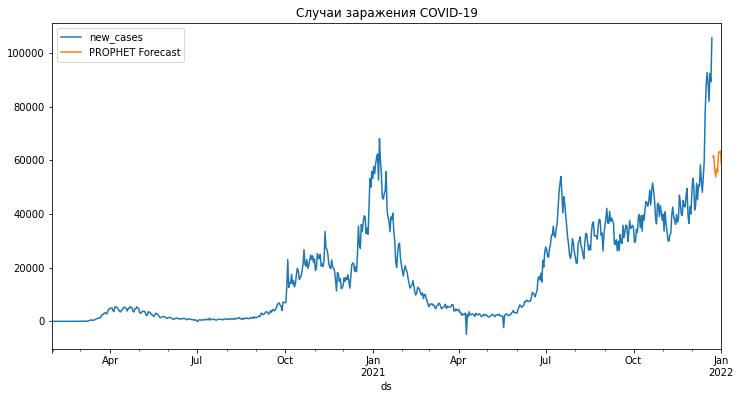

In [57]:
ax = df_new_prophet['y'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["new_cases", "PROPHET Forecast"]);

### Выводы работы метода PROPHET

---

Мы создали модель с подобранными параметрами,обучили модель на обучающей выборке данных.Сделали прогноз на 10 дней вперед. Модель показала о снижении кол-во заболеваймых. 

---

### 3й метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing):
Это метод прогнозирования временных рядов для одномерных данных, который может быть расширен для поддержки данных с систематическим трендом или сезонным компонентом.Метод математического преобразования, используемый при прогнозировании временных рядов.

Метод также известен как метод простого экспоненциального сглаживания, или метод Брауна

Cоздаем модель с подобранными параметрами

In [58]:
model_exps = ExponentialSmoothing(train['new_cases'], seasonal_periods=7, trend = 'add')


model_exps.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [59]:
model_exps.params

{'damping_trend': nan,
 'initial_level': 1.3333333333333326,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': 0.0121212121212122,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.8064285714285714,
 'smoothing_seasonal': nan,
 'smoothing_trend': 9.999999999999999e-05,
 'use_boxcox': False}

Предсказываем значения,передав модели results точку начала и окончания

In [60]:
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [61]:
test.index[0]

Timestamp('2021-12-13 00:00:00')

In [62]:
test.index[-1]

Timestamp('2021-12-22 00:00:00')

In [63]:
prediction_exps

array([49060.13775335, 49064.94882095, 49069.75988855, 49074.57095615,
       49079.38202375, 49084.19309134, 49089.00415894, 49093.81522654,
       49098.62629414, 49103.43736174])

Преобразуем в датафрейм с индексами

In [64]:
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2021-12-10 00:00:00", periods=10, freq="D")

prediction_exps.columns = ['prediction_exps']

In [65]:
prediction_exps.head()

,prediction_exps
2021-12-10,49060.137753
2021-12-11,49064.948821
2021-12-12,49069.759889
2021-12-13,49074.570956
2021-12-14,49079.382024


Сравниваем прогноз и тестовую выборку

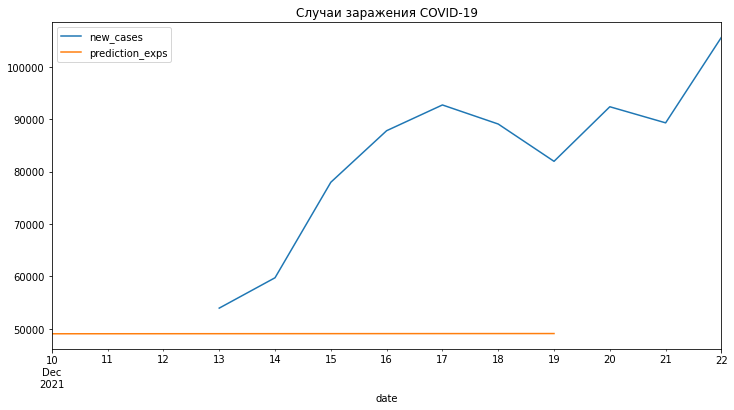

In [66]:
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [67]:
mae_error = mean_absolute_error(test['new_cases'], prediction_exps['prediction_exps'])
mse_error = mean_squared_error(test['new_cases'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['new_cases'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(2, 1, 1)x(1, 0, 1, 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(2, 1, 1)x(2, 0, 1, 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(2, 1, 1)x(2, 0, 1, 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(2, 1, 1)x(2, 0, 1, 7) MAPE Error: {mape_error:11.10}')

SARIMAX(2, 1, 1)x(1, 0, 1, 7) MAE Error: 33968.91244
SARIMAX(2, 1, 1)x(2, 0, 1, 7) MSE Error: 1.373997231e+09
SARIMAX(2, 1, 1)x(2, 0, 1, 7) RMSE Error: 37067.46864
SARIMAX(2, 1, 1)x(2, 0, 1, 7) MAPE Error: 34.29202356


Делаем прогноз на будущее - 10 дней вперед

In [68]:
fut_model_exps = ExponentialSmoothing(df_new['new_cases'], seasonal_periods=7, trend = 'add')
fut_model_exps.fit()


fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df_new)-1, end=len(df_new)+9)

fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2021-12-19", periods=11, freq="D")
fut_fcast_exps.columns = ['fut_fcast_exps']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [69]:
fut_fcast_exps.head()

,fut_fcast_exps
2021-12-19,89542.328924
2021-12-20,103660.269028
2021-12-21,103670.531932
2021-12-22,103680.794835
2021-12-23,103691.057738


Строим график на будущее

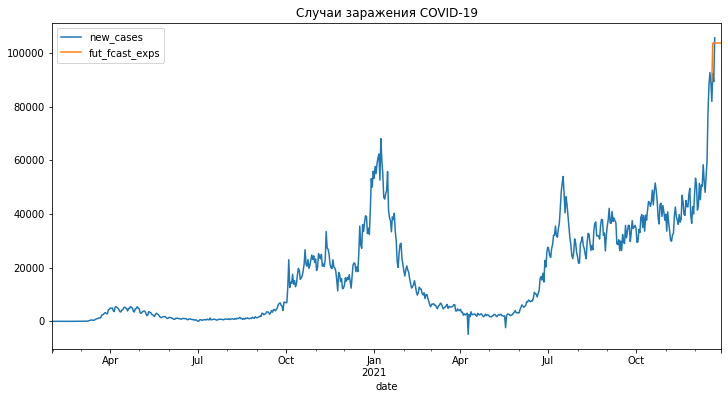

In [70]:
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

### Выводы работы метода Exponential smoothing

---
Мы создали  модель с подобранными параметрами, обучили ее.Сделали прогноз на 10 дней вперед,построили график . На графике мы видим ,что заболеваимость вырастит и выйдет на плато.

---

## Выводы

---
- Мы познакомились с разными методами и подходами к анализу и прогнозированию временных рядов.

- Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.

- Результаты анализа представленных данных помогли выявить зависимость новых случаев заражения и новых смертельных случаев от одних факторов.

- 1й метод прогнозирования - SARIMAX и 3й метод прогнозирования "Экспоненциальное сглаживание" позволили зафиксировать увеличение случаев заболевания. А 2й метод прогнозирования - PROPHET наоборт показал ,что заболевание будет ниже. 

- Лучше всех себя показал 1й метод прогнозирования - SARIMAX



---